##### A complex, multidisciplinary, and heterogeneous numerical model can be brken down into a series of chained (by passing variables from one to the next) smaller computations.

##### These smaller computations in OpenMDAO is performed inside a `Component` - Smallest unit of computational work. Every `Component` outputs it's own set of variables.



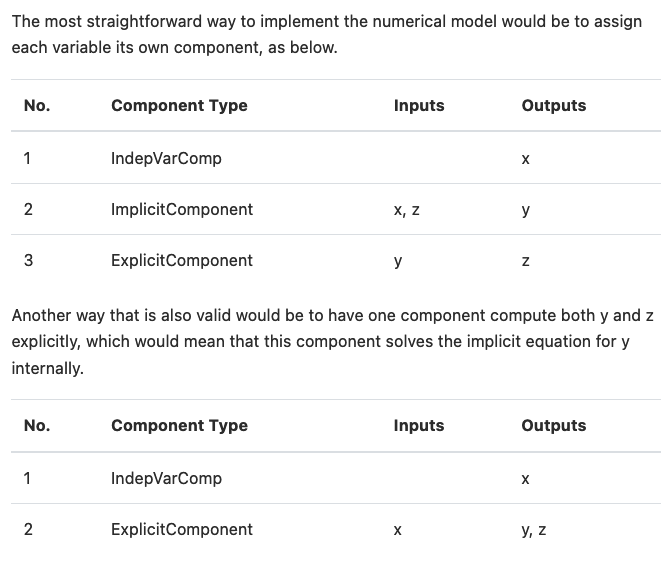

##### First way is recommended. Second way is more complicated because user must solve for `y` and `z` together, and also for  derivatives of `y` and `z` with `x`. This is non-trivial/significant.

##### OpenMDAO will automatically combine and assemble the derivatives from the components 2 and 3.

### Paraboloid - Single Discipline Model


In [67]:
import openmdao.api as om

# ExplicitComponent is contained in the openmdao.api module. This class is accessed through 'om.ExplicitComponent'.
class Paraboloid(om.ExplicitComponent):
    """
    Evaluates the equation f(x,y) = (x-3)^2 + xy + (y+4)^2 - 3.
    """

    def setup(self):
        self.add_input('x', val=0.0)
        self.add_input('y', val=0.0)

        self.add_output('f_xy', val=0.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        f(x,y) = (x-3)^2 + xy + (y+4)^2 - 3

        Minimum at: x = 6.6667; y = -7.3333
        """
        x = inputs['x']
        y = inputs['y']

        outputs['f_xy'] = (x - 3.0)**2 + x * y + (y + 4.0)**2 - 3.0


if __name__ == "__main__":

    model = om.Group()
    # parab_comp is an instance of the Paraboloid class
    model.add_subsystem('parab_comp', Paraboloid())

    # model Group with compoents, is passed to the constructor of the Problem class.
    prob = om.Problem(model)
    # call the setup() method on the problem.
    prob.setup()

    prob.set_val('parab_comp.x', 3.0)
    prob.set_val('parab_comp.y', -4.0)

    # to perform the computations
    prob.run_model()
    print(prob['parab_comp.f_xy'])

    # Trying twice with different input values
    prob.set_val('parab_comp.x', 5.0)
    prob.set_val('parab_comp.y', -2.0)

    prob.run_model()
    print(prob.get_val('parab_comp.f_xy'))

[-15.]
[-5.]


A class is a blueprint which you use to create objects. An object is an instance of a class - it's a concrete 'thing' that you made using a specific class. So, 'object' and 'instance' are the same thing, but the word 'instance' indicates the relationship of an object to its class.

This is easy to understand if you look at an example. For example, suppose you have a class House. Your own house is an object and is an instance of class House. Your sister's house is another object (another instance of class House).

// Class House describes what a house is
class House {
    // ...
}

// You can use class House to create objects (instances of class House)
House myHouse = new House();
House sistersHouse = new House();

The class House describes the concept of what a house is, and there are specific, concrete houses which are objects and instances of class House.

Note: This is exactly the same in Java as in all object oriented programming languages.


##### All OpenMDAO models are built from a hierarchy of `Group` instances which organize the components. In the above example, root group holds 1 component that is an instance/object to the `Paraboloid` class.

##### After defining hierarchy, the component is passed to the contructor of the `Problem` class. `setup()` method is called on the problem, which helps in getting data structures in place.

##### `run_model()` is called to perform the computation.

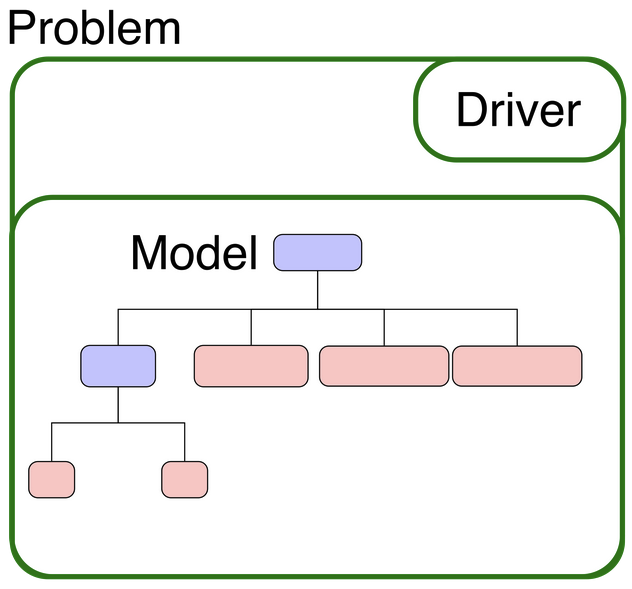

##### `Problem` class serves as a container for the model and the driver, and also has methods inside it to `run the model` and to `run the driver`. It is also an interface for setting and geting variable values.

##### Every `Problem` has a single driver associated with it, and has a single model in it.

In [68]:
import openmdao.api as om

# ExplicitComponent is contained in the openmdao.api module. This class is accessed through 'om.ExplicitComponent'.
class Paraboloid(om.ExplicitComponent):
    """
    Evaluates the equation f(x,y) = (x-3)^2 + xy + (y+4)^2 - 3.
    """

    def setup(self):
        self.add_input('x', val=0.0)
        self.add_input('y', val=0.0)

        self.add_output('f_xy', val=0.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        f(x,y) = (x-3)^2 + xy + (y+4)^2 - 3

        Minimum at: x = 6.6667; y = -7.3333
        """
        x = inputs['x']
        y = inputs['y']

        outputs['f_xy'] = (x - 3.0)**2 + x * y + (y + 4.0)**2 - 3.0
        
# build the model
prob = om.Problem()
prob.model.add_subsystem('parab', Paraboloid(), promotes_inputs=['x', 'y'])

# define the component whose output will be constrained
prob.model.add_subsystem('const', om.ExecComp('g = x + y'), promotes_inputs=['x', 'y'])

# Design variables 'x' and 'y' span components, so we need to provide a common initial
# value for them.
prob.model.set_input_defaults('x', 3.0)
prob.model.set_input_defaults('y', -4.0)

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'COBYLA'

prob.model.add_design_var('x', lower=-50, upper=50)
prob.model.add_design_var('y', lower=-50, upper=50)
prob.model.add_objective('parab.f_xy')

# to add the constraint to the model
prob.model.add_constraint('const.g', lower=0, upper=10.)

prob.setup()
prob.run_driver();


Optimization Complete
-----------------------------------

   Normal return from subroutine COBYLA

   NFVALS =   54   F =-2.700000E+01    MAXCV =-0.000000E+00
   X = 6.999999E+00  -6.999999E+00


In [69]:
# minimum value
print(prob.get_val('parab.f_xy'))

[-27.]


In [70]:
# location of the minimum
print(prob.get_val('x'))
print(prob.get_val('y'))

[6.99999912]
[-6.99999912]


#### Now we have added another another equation `x = -y = 7.0` through 'g = x + y' under `const` component.

In [71]:
! openmdao n2 OpenMDAO-basic-userguide-1.py

In [72]:
! openmdao n2 OpenMDAO-basic-userguide-2.py

In [73]:
import openmdao.api as om
import numpy as np

class SellarDis1(om.ExplicitComponent):
    """
    Component containing Discipline 1 -- no derivatives version.
    """

    def setup(self):

        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Local Design Variable
        self.add_input('x', val=0.)

        # Coupling parameter
        self.add_input('y2', val=1.0)

        # Coupling output
        self.add_output('y1', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y1 = z1**2 + z2 + x1 - 0.2*y2
        """
        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        x1 = inputs['x']
        y2 = inputs['y2']

        outputs['y1'] = z1**2 + z2 + x1 - 0.2*y2
        
        
class SellarDis2(om.ExplicitComponent):
    """
    Component containing Discipline 2 -- no derivatives version.
    """

    def setup(self):
        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Coupling parameter
        self.add_input('y1', val=1.0)

        # Coupling output
        self.add_output('y2', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y2 = y1**(.5) + z1 + z2
        """

        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        y1 = inputs['y1']

        # Note: this may cause some issues. However, y1 is constrained to be
        # above 3.16, so lets just let it converge, and the optimizer will
        # throw it out
        if y1.real < 0.0:
            y1 *= -1

        outputs['y2'] = y1**.5 + z1 + z2
        
        
class SellarMDA(om.Group):
    """
    Group containing the Sellar MDA.
    """

    def setup(self):
        cycle = self.add_subsystem('cycle', om.Group(), promotes=['*'])
        cycle.add_subsystem('d1', SellarDis1(), promotes_inputs=['x', 'z', 'y2'],
                            promotes_outputs=['y1'])
        cycle.add_subsystem('d2', SellarDis2(), promotes_inputs=['z', 'y1'],
                            promotes_outputs=['y2'])

        cycle.set_input_defaults('x', 1.0)
        cycle.set_input_defaults('z', np.array([5.0, 2.0]))

        # Nonlinear Block Gauss Seidel is a gradient free solver
        cycle.nonlinear_solver = om.NonlinearBlockGS()

        self.add_subsystem('obj_cmp', om.ExecComp('obj = x**2 + z[1] + y1 + exp(-y2)',
                                                  z=np.array([0.0, 0.0]), x=0.0),
                           promotes=['x', 'z', 'y1', 'y2', 'obj'])

        self.add_subsystem('con_cmp1', om.ExecComp('con1 = 3.16 - y1'), promotes=['con1', 'y1'])
        self.add_subsystem('con_cmp2', om.ExecComp('con2 = y2 - 24.0'), promotes=['con2', 'y2'])
        
prob = om.Problem()
prob.model = SellarMDA()

prob.setup()

prob.set_val('x', 2.0)
prob.set_val('z', [-1., -1.])

prob.run_model()


=====
cycle
=====
NL: NLBGS Converged in 10 iterations


In [74]:
! openmdao n2 OpenMDAO-basic-userguide-3.py

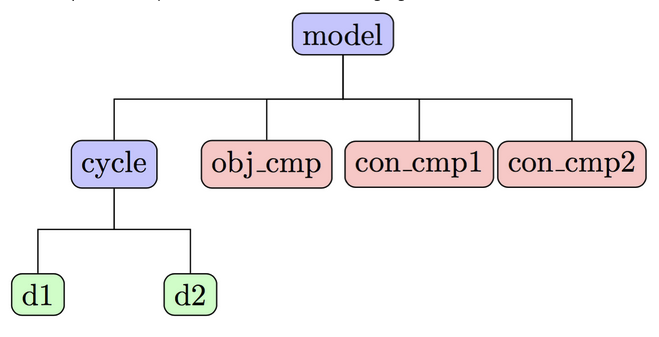

The `NonlinearBlockGaussSeidel` solver, also sometimes called a “fixed-point iteration solver,” is a gradient-free method that works well in many situations. More tightly-coupled problems, or problems with instances of `ImplicitComponent` that don’t implement their own `solve_nonlinear` method, will require the `Newton` solver.

In [75]:
import openmdao.api as om
import numpy as np

class SellarDis1(om.ExplicitComponent):
    """
    Component containing Discipline 1 -- no derivatives version.
    """

    def setup(self):

        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Local Design Variable
        self.add_input('x', val=0.)

        # Coupling parameter
        self.add_input('y2', val=1.0)

        # Coupling output
        self.add_output('y1', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y1 = z1**2 + z2 + x1 - 0.2*y2
        """
        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        x1 = inputs['x']
        y2 = inputs['y2']

        outputs['y1'] = z1**2 + z2 + x1 - 0.2*y2
        
        
class SellarDis2(om.ExplicitComponent):
    """
    Component containing Discipline 2 -- no derivatives version.
    """

    def setup(self):
        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Coupling parameter
        self.add_input('y1', val=1.0)

        # Coupling output
        self.add_output('y2', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y2 = y1**(.5) + z1 + z2
        """

        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        y1 = inputs['y1']

        # Note: this may cause some issues. However, y1 is constrained to be
        # above 3.16, so lets just let it converge, and the optimizer will
        # throw it out
        if y1.real < 0.0:
            y1 *= -1

        outputs['y2'] = y1**.5 + z1 + z2
        
        

class SellarMDA(om.Group):
    """
    Group containing the Sellar MDA.
    """

    def setup(self):
        # set up model hierarchy
        cycle = self.add_subsystem('cycle', om.Group())
        cycle.add_subsystem('d1', SellarDis1())
        cycle.add_subsystem('d2', SellarDis2())

        cycle.nonlinear_solver = om. NonlinearBlockGS()

        self.add_subsystem('obj_cmp', om.ExecComp('obj = x**2 + z[1] + y1 + exp(-y2)',
                                                  z=np.array([0.0, 0.0]), x=0.0))

        self.add_subsystem('con_cmp1', om.ExecComp('con1 = 3.16 - y1'))
        self.add_subsystem('con_cmp2', om.ExecComp('con2 = y2 - 24.0'))

    def configure(self):
        # connect everything via promotes
        self.cycle.promotes('d1', inputs=['x', 'z', 'y2'], outputs=['y1'])
        self.cycle.promotes('d2', inputs=['z', 'y1'], outputs=['y2'])

        self.promotes('cycle', any=['*'])

        self.promotes('obj_cmp', any=['x', 'z', 'y1', 'y2', 'obj'])
        self.promotes('con_cmp1', any=['con1', 'y1'])
        self.promotes('con_cmp2', any=['con2', 'y2'])


prob = om.Problem()
prob.model = SellarMDA()

prob.setup()

prob.set_val('x', 2.0)
prob.set_val('z', [-1., -1.])

prob.run_model()



=====
cycle
=====
NL: NLBGS Converged in 10 iterations


In [76]:
! openmdao n2 OpenMDAO-basic-userguide-4.py

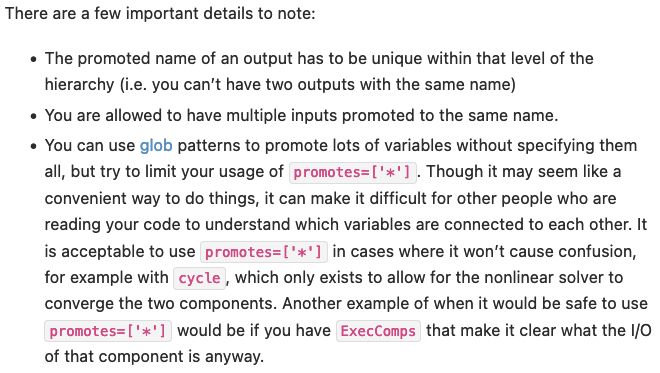

### Variable Connection

In [77]:
import openmdao.api as om
import numpy as np

class SellarDis1(om.ExplicitComponent):
    """
    Component containing Discipline 1 -- no derivatives version.
    """

    def setup(self):

        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Local Design Variable
        self.add_input('x', val=0.)

        # Coupling parameter
        self.add_input('y2', val=1.0)

        # Coupling output
        self.add_output('y1', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y1 = z1**2 + z2 + x1 - 0.2*y2
        """
        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        x1 = inputs['x']
        y2 = inputs['y2']

        outputs['y1'] = z1**2 + z2 + x1 - 0.2*y2
        
        
class SellarDis2(om.ExplicitComponent):
    """
    Component containing Discipline 2 -- no derivatives version.
    """

    def setup(self):
        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Coupling parameter
        self.add_input('y1', val=1.0)

        # Coupling output
        self.add_output('y2', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y2 = y1**(.5) + z1 + z2
        """

        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        y1 = inputs['y1']

        # Note: this may cause some issues. However, y1 is constrained to be
        # above 3.16, so lets just let it converge, and the optimizer will
        # throw it out
        if y1.real < 0.0:
            y1 *= -1

        outputs['y2'] = y1**.5 + z1 + z2
        
        
class SellarMDAConnect(om.Group):
    """
    Group containing the Sellar MDA. This version uses the disciplines without derivatives.
    """

    def setup(self):
        cycle = self.add_subsystem('cycle', om.Group(),
                                   promotes_inputs=['x', 'z'])
        cycle.add_subsystem('d1', SellarDis1(),
                            promotes_inputs=['x', 'z'])
        cycle.add_subsystem('d2', SellarDis2(),
                            promotes_inputs=['z'])
        cycle.connect('d1.y1', 'd2.y1')
        cycle.connect('d2.y2', 'd1.y2')

        cycle.set_input_defaults('x', 1.0)
        cycle.set_input_defaults('z', np.array([5.0, 2.0]))

        # Nonlinear Block Gauss Seidel is a gradient free solver
        cycle.nonlinear_solver = om.NonlinearBlockGS()

        self.add_subsystem('obj_cmp', om.ExecComp('obj = x**2 + z[1] + y1 + exp(-y2)',
                                                  z=np.array([0.0, 0.0]), x=0.0),
                           promotes_inputs=['x', 'z'])

        self.add_subsystem('con_cmp1', om.ExecComp('con1 = 3.16 - y1'))
        self.add_subsystem('con_cmp2', om.ExecComp('con2 = y2 - 24.0'))

        self.connect('cycle.d1.y1', ['obj_cmp.y1', 'con_cmp1.y1'])
        self.connect('cycle.d2.y2', ['obj_cmp.y2', 'con_cmp2.y2'])

prob = om.Problem()
prob.model = SellarMDAConnect()

prob.setup()

prob.set_val('x', 2.0)
prob.set_val('z', [-1., -1.])

prob.run_model()


=====
cycle
=====
NL: NLBGS Converged in 10 iterations


### Variable Promotion and Connection


In [78]:
import openmdao.api as om
import numpy as np

class SellarDis1(om.ExplicitComponent):
    """
    Component containing Discipline 1 -- no derivatives version.
    """

    def setup(self):

        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Local Design Variable
        self.add_input('x', val=0.)

        # Coupling parameter
        self.add_input('y2', val=1.0)

        # Coupling output
        self.add_output('y1', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y1 = z1**2 + z2 + x1 - 0.2*y2
        """
        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        x1 = inputs['x']
        y2 = inputs['y2']

        outputs['y1'] = z1**2 + z2 + x1 - 0.2*y2
        
        
class SellarDis2(om.ExplicitComponent):
    """
    Component containing Discipline 2 -- no derivatives version.
    """

    def setup(self):
        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Coupling parameter
        self.add_input('y1', val=1.0)

        # Coupling output
        self.add_output('y2', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y2 = y1**(.5) + z1 + z2
        """

        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        y1 = inputs['y1']

        # Note: this may cause some issues. However, y1 is constrained to be
        # above 3.16, so lets just let it converge, and the optimizer will
        # throw it out
        if y1.real < 0.0:
            y1 *= -1

        outputs['y2'] = y1**.5 + z1 + z2
        
        
class SellarMDAPromoteConnect(om.Group):
    """
    Group containing the Sellar MDA. This version uses the disciplines without derivatives.
    """

    def setup(self):
        cycle = self.add_subsystem('cycle', om.Group(), promotes=['*'])
        cycle.add_subsystem('d1', SellarDis1(),
                            promotes_inputs=['x', 'z'])
        cycle.add_subsystem('d2', SellarDis2(),
                            promotes_inputs=['z'])
        cycle.connect('d1.y1', 'd2.y1')
        cycle.connect('d2.y2', 'd1.y2')

        cycle.set_input_defaults('x', 1.0)
        cycle.set_input_defaults('z', np.array([5.0, 2.0]))

        # Nonlinear Block Gauss Seidel is a gradient free solver
        cycle.nonlinear_solver = om.NonlinearBlockGS()

        self.add_subsystem('obj_cmp', om.ExecComp('obj = x**2 + z[1] + y1 + exp(-y2)',
                                                  z=np.array([0.0, 0.0]), x=0.0),
                           promotes_inputs=['x', 'z'])

        self.add_subsystem('con_cmp1', om.ExecComp('con1 = 3.16 - y1'))
        self.add_subsystem('con_cmp2', om.ExecComp('con2 = y2 - 24.0'))

        self.connect('d1.y1', ['con_cmp1.y1', 'obj_cmp.y1'])
        self.connect('d2.y2', ['con_cmp2.y2', 'obj_cmp.y2'])


prob = om.Problem()
prob.model = SellarMDAPromoteConnect()

prob.setup()

prob.set_val('x', 2.0)
prob.set_val('z', [-1., -1.])

prob.run_model()


=====
cycle
=====
NL: NLBGS Converged in 10 iterations


## Optimizing Sellar Problem

In [79]:
import openmdao.api as om
import numpy as np

class SellarDis1(om.ExplicitComponent):
    """
    Component containing Discipline 1 -- no derivatives version.
    """

    def setup(self):

        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Local Design Variable
        self.add_input('x', val=0.)

        # Coupling parameter
        self.add_input('y2', val=1.0)

        # Coupling output
        self.add_output('y1', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y1 = z1**2 + z2 + x1 - 0.2*y2
        """
        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        x1 = inputs['x']
        y2 = inputs['y2']

        outputs['y1'] = z1**2 + z2 + x1 - 0.2*y2
        
        
class SellarDis2(om.ExplicitComponent):
    """
    Component containing Discipline 2 -- no derivatives version.
    """

    def setup(self):
        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Coupling parameter
        self.add_input('y1', val=1.0)

        # Coupling output
        self.add_output('y2', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y2 = y1**(.5) + z1 + z2
        """

        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        y1 = inputs['y1']

        # Note: this may cause some issues. However, y1 is constrained to be
        # above 3.16, so lets just let it converge, and the optimizer will
        # throw it out
        if y1.real < 0.0:
            y1 *= -1

        outputs['y2'] = y1**.5 + z1 + z2
        
        
class SellarMDA(om.Group):
    """
    Group containing the Sellar MDA.
    """

    def setup(self):
        cycle = self.add_subsystem('cycle', om.Group(), promotes=['*'])
        cycle.add_subsystem('d1', SellarDis1(), promotes_inputs=['x', 'z', 'y2'],
                            promotes_outputs=['y1'])
        cycle.add_subsystem('d2', SellarDis2(), promotes_inputs=['z', 'y1'],
                            promotes_outputs=['y2'])

        cycle.set_input_defaults('x', 1.0)
        cycle.set_input_defaults('z', np.array([5.0, 2.0]))

        # Nonlinear Block Gauss Seidel is a gradient free solver
        cycle.nonlinear_solver = om.NonlinearBlockGS()

        self.add_subsystem('obj_cmp', om.ExecComp('obj = x**2 + z[1] + y1 + exp(-y2)',
                                                  z=np.array([0.0, 0.0]), x=0.0),
                           promotes=['x', 'z', 'y1', 'y2', 'obj'])

        self.add_subsystem('con_cmp1', om.ExecComp('con1 = 3.16 - y1'), promotes=['con1', 'y1'])
        self.add_subsystem('con_cmp2', om.ExecComp('con2 = y2 - 24.0'), promotes=['con2', 'y2'])
        

prob = om.Problem()
prob.model = SellarMDA()

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
# prob.driver.options['maxiter'] = 100
prob.driver.options['tol'] = 1e-8

prob.model.add_design_var('x', lower=0, upper=10)
prob.model.add_design_var('z', lower=0, upper=10)
prob.model.add_objective('obj')
prob.model.add_constraint('con1', upper=0)
prob.model.add_constraint('con2', upper=0)

# Ask OpenMDAO to finite-difference across the model to compute the gradients for the optimizer
prob.model.approx_totals()
# One can define method also in following way 'model.approx_totals(method='cs')'


prob.setup()
prob.set_solver_print(level=0)

prob.run_driver()

print('minimum found at')
print(prob.get_val('x')[0])
print(prob.get_val('z'))

print('minumum objective')
print(prob.get_val('obj')[0])

of = ['z']
wrt = ['x']
derivs = prob.compute_totals(of=of, wrt=wrt)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.183393951729169
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization Complete
-----------------------------------
minimum found at
0.0
[1.97763888e+00 8.83056605e-15]
minumum objective
3.183393951729169


In [80]:
print(derivs['',''])

print(derivs['z', 'x'])

print(Component._exec_count)

KeyError: ('', '')

### Sanity Checking Model

In [82]:
import openmdao.api as om
import numpy as np

class SellarDis1(om.ExplicitComponent):
    """
    Component containing Discipline 1 -- no derivatives version.
    """

    def setup(self):

        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Local Design Variable
        self.add_input('x', val=0.)

        # Coupling parameter
        self.add_input('y2', val=1.0)

        # Coupling output
        self.add_output('y1', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y1 = z1**2 + z2 + x1 - 0.2*y2
        """
        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        x1 = inputs['x']
        y2 = inputs['y2']

        outputs['y1'] = z1**2 + z2 + x1 - 0.2*y2
        
        
class SellarDis2(om.ExplicitComponent):
    """
    Component containing Discipline 2 -- no derivatives version.
    """

    def setup(self):
        # Global Design Variable
        self.add_input('z', val=np.zeros(2))

        # Coupling parameter
        self.add_input('y1', val=1.0)

        # Coupling output
        self.add_output('y2', val=1.0)

    def setup_partials(self):
        # Finite difference all partials.
        self.declare_partials('*', '*', method='fd')

    def compute(self, inputs, outputs):
        """
        Evaluates the equation
        y2 = y1**(.5) + z1 + z2
        """

        z1 = inputs['z'][0]
        z2 = inputs['z'][1]
        y1 = inputs['y1']

        # Note: this may cause some issues. However, y1 is constrained to be
        # above 3.16, so lets just let it converge, and the optimizer will
        # throw it out
        if y1.real < 0.0:
            y1 *= -1

        outputs['y2'] = y1**.5 + z1 + z2

class SellarMDAConnect(om.Group):

    def setup(self):
        cycle = self.add_subsystem('cycle', om.Group(), promotes_inputs=['x', 'z'])
        cycle.add_subsystem('d1', SellarDis1(), promotes_inputs=['x', 'z'])
        cycle.add_subsystem('d2', SellarDis2(), promotes_inputs=['z'])
        cycle.connect('d1.y1', 'd2.y1')

        ######################################
        # This is a "forgotten" connection!!
        ######################################
        #cycle.connect('d2.y2', 'd1.y2')

        cycle.set_input_defaults('x', 1.0)
        cycle.set_input_defaults('z', np.array([5.0, 2.0]))

        # Nonlinear Block Gauss Seidel is a gradient free solver
        cycle.nonlinear_solver = om.NonlinearBlockGS()

        self.add_subsystem('obj_cmp', om.ExecComp('obj = x**2 + z[1] + y1 + exp(-y2)',
                                                  z=np.array([0.0, 0.0]), x=0.0),
                           promotes_inputs=['x', 'z'])

        self.add_subsystem('con_cmp1', om.ExecComp('con1 = 3.16 - y1'))
        self.add_subsystem('con_cmp2', om.ExecComp('con2 = y2 - 24.0'))

        self.connect('cycle.d1.y1', ['obj_cmp.y1', 'con_cmp1.y1'])
        self.connect('cycle.d2.y2', ['obj_cmp.y2', 'con_cmp2.y2'])


prob = om.Problem()

prob.model = SellarMDAConnect()

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
# prob.driver.options['maxiter'] = 100
prob.driver.options['tol'] = 1e-8

prob.set_solver_print(level=0)

prob.model.add_design_var('x', lower=0, upper=10)
prob.model.add_design_var('z', lower=0, upper=10)
prob.model.add_objective('obj_cmp.obj')
prob.model.add_constraint('con_cmp1.con1', upper=0)
prob.model.add_constraint('con_cmp2.con2', upper=0)

prob.setup()

prob.set_val('x', 2.0)
prob.set_val('z', [-1., -1.])

prob.run_driver()
print('minimum found at')
print(prob.get_val('x')[0])
print(prob.get_val('z'))
print('minumum objective')
print(prob.get_val('obj_cmp.obj')[0])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1870337508695563
            Iterations: 9
            Function evaluations: 10
            Gradient evaluations: 9
Optimization Complete
-----------------------------------
minimum found at
0.0
[1.83303028 0.        ]
minumum objective
3.1870337508695563


/Users/h1he2li3/opt/anaconda3/envs/dymos_rangemax/lib/python3.11/site-packages/openmdao/core/driver.py:470: DriverWarning:The following design variable initial conditions are out of their specified bounds:
  z
    val: [-1. -1.]
    lower: 0.0
    upper: 10.0
Set the initial value of the design variable to a valid value or set the driver option['invalid_desvar_behavior'] to 'ignore'.


In [81]:
!openmdao check -c all OpenMDAO-basic-userguide-5.py

INFO: checking all_unserializable_options
INFO: checking auto_ivc_warnings
INFO: checking comp_has_no_outputs
INFO: checking cycles
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking out_of_order
INFO: checking promotions
INFO: checking solvers
INFO: checking system
INFO: checking unconnected_inputs
  cycle.d1.y2 (cycle.d1.y2)



In [84]:
! openmdao n2 OpenMDAO-basic-userguide-5.py

In [85]:
class SellarMDAWithUnits(om.Group):
    """
    Group containing the Sellar MDA.
    """

    class SellarDis1Units(om.ExplicitComponent):
        """
        Component containing Discipline 1 -- no derivatives version.
        """

        def setup(self):

            # Global Design Variable
            self.add_input('z', val=np.zeros(2), units='degC')

            # Local Design Variable
            self.add_input('x', val=0., units='degC')

            # Coupling parameter
            self.add_input('y2', val=1.0, units='degC')

            # Coupling output
            self.add_output('y1', val=1.0, units='degC')

        def setup_partials(self):
            # Finite difference all partials.
            self.declare_partials('*', '*', method='fd')

        def compute(self, inputs, outputs):
            """
            Evaluates the equation
            y1 = z1**2 + z2 + x1 - 0.2*y2
            """
            z1 = inputs['z'][0]
            z2 = inputs['z'][1]
            x1 = inputs['x']
            y2 = inputs['y2']

            outputs['y1'] = z1**2 + z2 + x1 - 0.2*y2


    class SellarDis2Units(om.ExplicitComponent):
        """
        Component containing Discipline 2 -- no derivatives version.
        """

        def setup(self):
            # Global Design Variable
            self.add_input('z', val=np.zeros(2), units='degC')

            # Coupling parameter
            self.add_input('y1', val=1.0, units='degC')

            # Coupling output
            self.add_output('y2', val=1.0, units='degC')

        def setup_partials(self):
            # Finite difference all partials.
            self.declare_partials('*', '*', method='fd')

        def compute(self, inputs, outputs):
            """
            Evaluates the equation
            y2 = y1**(.5) + z1 + z2
            """

            z1 = inputs['z'][0]
            z2 = inputs['z'][1]
            y1 = inputs['y1']

            # Note: this may cause some issues. However, y1 is constrained to be
            # above 3.16, so lets just let it converge, and the optimizer will
            # throw it out
            if y1.real < 0.0:
                y1 *= -1

            outputs['y2'] = y1**.5 + z1 + z2

    def setup(self):

        cycle = self.add_subsystem('cycle', om.Group(), promotes=['*'])
        cycle.add_subsystem('d1', self.SellarDis1Units(), promotes_inputs=['x', 'z', 'y2'],
                            promotes_outputs=['y1'])
        cycle.add_subsystem('d2', self.SellarDis2Units(), promotes_inputs=['z', 'y1'],
                            promotes_outputs=['y2'])

        cycle.set_input_defaults('x', 1.0, units='degC')
        cycle.set_input_defaults('z', np.array([5.0, 2.0]), units='degC')

        # Nonlinear Block Gauss Seidel is a gradient free solver
        cycle.nonlinear_solver = om.NonlinearBlockGS()

        self.add_subsystem('obj_cmp', om.ExecComp('obj = x**2 + z[1] + y1 + exp(-y2)',
                                                  z={'val': np.array([0.0, 0.0]), 'units': 'degC'},
                                                  x={'val': 0.0, 'units': 'degC'},
                                                  y1={'units': 'degC'},
                                                  y2={'units': 'degC'}),
                           promotes=['x', 'z', 'y1', 'y2', 'obj'])

        self.add_subsystem('con_cmp1', om.ExecComp('con1 = 3.16 - y1', y1={'units': 'degC'},
                                                   con1={'units': 'degC'}),
                           promotes=['con1', 'y1'])
        self.add_subsystem('con_cmp2', om.ExecComp('con2 = y2 - 24.0', y2={'units': 'degC'},
                                                   con2={'units': 'degC'}),
                           promotes=['con2', 'y2'])



from openmdao.test_suite.components.sellar_feature import SellarMDAWithUnits
import numpy as np
import openmdao.api as om

# build the model
prob = om.Problem(model=SellarMDAWithUnits())

model = prob.model
model.add_design_var('z', lower=np.array([-10.0, 0.0]), upper=np.array([10.0, 10.0]))
model.add_design_var('x', lower=0.0, upper=10.0)
model.add_objective('obj')
model.add_constraint('con1', upper=0.0)
model.add_constraint('con2', upper=0.0)

# setup the optimization
driver = prob.driver = om.ScipyOptimizeDriver(optimizer='SLSQP', tol=1e-9, disp=False)

# Create a recorder variable
recorder = om.SqliteRecorder('cases.sql')
# Attach a recorder to the problem
prob.add_recorder(recorder)

prob.setup()
prob.set_solver_print(0)
prob.run_driver()
prob.record("after_run_driver")

# Instantiate your CaseReader
cr = om.CaseReader("cases.sql")
# Isolate "problem" as your source
driver_cases = cr.list_cases('problem', out_stream=None)
# Get the first case from the recorder
case = cr.get_case('after_run_driver')

# These options will give outputs as the model sees them
# Gets value but will not convert units
const = case['con1']
print(const)

# get_val can convert your result's units if desired
const_K = case.get_val("con1", units='K')

print(const_K)

[-1.68550507e-10]
[273.15]


In [86]:
print(case.list_outputs())

5 Explicit Output(s) in 'model'

varname   val              
--------  -----------------
cycle
  d1
    y1    [3.16]           
  d2
    y2    [3.75527777]     
obj_cmp
  obj     [3.18339395]     
con_cmp1
  con1    [-1.68550507e-10]
con_cmp2
  con2    [-20.24472223]   


0 Implicit Output(s) in 'model'


[('con_cmp1.con1', {'val': array([-1.68550507e-10])}), ('con_cmp2.con2', {'val': array([-20.24472223])}), ('cycle.d1.y1', {'val': array([3.16])}), ('cycle.d2.y2', {'val': array([3.75527777])}), ('obj_cmp.obj', {'val': array([3.18339395])})]


In [87]:
# This code below will find all the objectives, design variables, and constraints that the
# problem source contains
objectives = case.get_objectives()
print(objectives['obj'])

design_vars = case.get_design_vars()
print(design_vars['x'])

constraints = case.get_constraints()
print(constraints['con1'])

[3.18339395]
[0.]
[-1.68550507e-10]
